# Beyond example_BIDS.py

This notebook is going to follow some steps already explained in example_BIDS.ipynb, but with some extensions:
1. Show how the user can plot the cortical grid
2. Show how the user can visualize the sharpwave features
3. Show how the user can set their preferred Machine Learning model and cross-validation method

(We suggest you first follow example_BIDS.py and then come back here)

Again we start with importing the necessary packages:

In [1]:
import os
import sys

# change root directory of the project
SCRIPT_DIR = os.path.dirname(os.path.abspath(''))
if os.path.basename(SCRIPT_DIR) == "py_neuromodulation":
    # this check is necessary, so we can also run the script from the root directory
    SCRIPT_DIR = os.path.join(SCRIPT_DIR, "examples")

sys.path.append(os.path.dirname(SCRIPT_DIR))

# Reload imports to get changes in other scripts
%load_ext autoreload
%autoreload 2

In [2]:
import py_neuromodulation as nm
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
)
from sklearn import metrics, model_selection
from skopt import space as skopt_space
from scipy import io
import numpy as np
import matplotlib.pyplot as plt

c:\Users\ICN_admin\Anaconda3\envs\pn_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Read BIDS data

For an example with simulated data and/or in a different format, please look into example_SimulatedData

In [3]:
SCRIPT_DIR

'c:\\code\\py_neuromodulation\\examples'

In [4]:
sub = "testsub"
ses = "EphysMedOff"
task = "buttonpress"
run = 0
datatype = "ieeg"

# Define run name and access paths in the BIDS format.
RUN_NAME = f"sub-{sub}_ses-{ses}_task-{task}_run-{run}"

PATH_RUN = os.path.join(
    (os.path.join(SCRIPT_DIR, "data")),
    f"sub-{sub}",
    f"ses-{ses}",
    datatype,
    RUN_NAME,
)
PATH_BIDS = os.path.join(SCRIPT_DIR, "data")

# Provide a path for the output data.
PATH_OUT = os.path.join(SCRIPT_DIR, "data", "derivatives")

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

Extracting parameters from c:\code\py_neuromodulation\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg.vhdr...
Setting channel info structure...
Reading channel info from c:\code\py_neuromodulation\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_channels.tsv.
Reading electrode coords from c:\code\py_neuromodulation\examples\data\sub-testsub\ses-EphysMedOff\ieeg\sub-testsub_ses-EphysMedOff_acq-StimOff_space-mni_electrodes.tsv.


## Define the channels

In [5]:
nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=("SQUARED_ROTATION",),
)

In [6]:
nm_channels

,name,rereference,used,target,type,status,new_name
0,ANALOG_R_ROTA_CH,None,0,0,misc,good,ANALOG_R_ROTA_CH
1,ECOG_L_1_SMC_AT,average,1,0,ecog,good,ECOG_L_1_SMC_AT-avgref
2,ECOG_L_2_SMC_AT,average,1,0,ecog,good,ECOG_L_2_SMC_AT-avgref
3,ECOG_L_3_SMC_AT,average,1,0,ecog,good,ECOG_L_3_SMC_AT-avgref
4,ECOG_L_4_SMC_AT,average,1,0,ecog,good,ECOG_L_4_SMC_AT-avgref
5,ECOG_L_5_SMC_AT,average,1,0,ecog,good,ECOG_L_5_SMC_AT-avgref
6,ECOG_L_6_SMC_AT,average,1,0,ecog,good,ECOG_L_6_SMC_AT-avgref
7,EEG_AO,None,0,0,misc,good,EEG_AO
8,LFP_L_1_STN_BS,LFP_L_567_STN_BS,1,0,seeg,good,LFP_L_1_STN_BS-LFP_L_567_STN_BS
9,LFP_L_234_STN_BS,LFP_L_1_STN_BS,1,0,seeg,good,LFP_L_234_STN_BS-LFP_L_1_STN_BS


The data contains depth LFP electrodes from the Subthalamic Nucleus (STN) and a ECoG strip electrode. Bipolar rereferencing was defined by default for the depth electrodes, and common average rereference for the ECoG electrodes. Importantly "SQUARED_ROTATION" is used as a target channel. After feature estimation, this channel will be normalized and added in a time aligned manner to the features output csv file.

## Settings for Feature Estimation

In [7]:
stream = nm.Stream(
    settings=None,
    nm_channels=nm_channels,
    path_grids=None,
    verbose=True,
)

When the Stream class is initialized with "settings=None", the settings for the feature estimation are imported from the nm_settings.json file. In the cell below we display those settings:

In [8]:
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': True,
  'raw_normalization': True,
  're_referencing': True,
  'notch_filter': True,
  'preprocessing_order': ['raw_resampling',
   'notch_filter',
   're_referencing',
   'raw_normalization']},
 'features': {'raw_hjorth': True,
  'return_raw': True,
  'bandpass_filter': True,
  'stft': True,
  'fft': True,
  'sharpwave_analysis': True,
  'coherence': True,
  'fooof': True,
  'nolds': True,
  'bursts': True},
 'postprocessing': {'feature_normalization': True,
  'project_cortex': True,
  'project_subcortex': True},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],
  'hig

Now, if the user wants to use a different set of settings, they can either change the nm_settings.json file, or from the script alter them.

Here, we first use stream.reset_settings(), which sets the preprocessing steps to false, as well as the desired features and the postprocessing steps. In that way, we need to select all steps from preprocessing, feature estimation and postprocessing that we want to perform, just by setting them = True.

In [9]:
stream.reset_settings()
stream.settings

{'sampling_rate_features_hz': 10,
 'segment_length_features_ms': 1000,
 'preprocessing': {'raw_resampling': False,
  'raw_normalization': False,
  're_referencing': False,
  'notch_filter': False,
  'preprocessing_order': []},
 'features': {'raw_hjorth': False,
  'return_raw': False,
  'bandpass_filter': False,
  'stft': False,
  'fft': False,
  'sharpwave_analysis': False,
  'coherence': False,
  'fooof': False,
  'nolds': False,
  'bursts': False},
 'postprocessing': {'feature_normalization': False,
  'project_cortex': False,
  'project_subcortex': False},
 'raw_resampling_settings': {'resample_freq_hz': 1000},
 'raw_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time_s': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'frequency_ranges_hz': {'theta': [4, 8],
  'alpha': [8, 12],
  'low beta': [13, 20],
  'high beta': [20, 35],
  'low gamma': [60, 80],
  'high gamma': [90

Now we manually set to True all steps that we want to be performed in the feature estimation.

In [10]:
# We first take care of the preprocessing steps - and here we want to perform all of them in the order given by stream.settings['preprocessing']['preprocessing_order']

stream.settings['preprocessing']['raw_resampling'] = True
stream.settings['preprocessing']['raw_normalization'] = True
stream.settings['preprocessing']['re_referencing'] = True
stream.settings['preprocessing']['notch_filter'] = True
stream.settings['preprocessing']['preprocessing_order'] = [
            "raw_resampling",
            "notch_filter",
            "re_referencing",
            "raw_normalization"
        ]

# Now we focus on the features that we want to estimate:

stream.settings['features']['raw_hjorth'] = True
stream.settings['features']['bandpass_filter'] = True
stream.settings['features']['fft'] = True
stream.settings['features']['sharpwave_analysis'] = True
stream.settings['features']['fooof'] = False
stream.settings['features']['nolds'] = False

# Then we set the postprocessing steps
stream.settings['postprocessing']['feature_normalization'] = False
stream.settings['postprocessing']['project_cortex'] = True
stream.settings['postprocessing']['project_subcortex'] = True

In [11]:
stream.settings["sharpwave_analysis_settings"]

{'sharpwave_features': {'peak_left': False,
  'peak_right': False,
  'trough': False,
  'width': False,
  'prominence': True,
  'interval': True,
  'decay_time': False,
  'rise_time': False,
  'sharpness': True,
  'rise_steepness': False,
  'decay_steepness': False,
  'slope_ratio': False},
 'filter_ranges_hz': [[5, 80], [5, 30]],
 'detect_troughs': {'estimate': True,
  'distance_troughs_ms': 10,
  'distance_peaks_ms': 5},
 'detect_peaks': {'estimate': True,
  'distance_troughs_ms': 5,
  'distance_peaks_ms': 10},
 'estimator': {'mean': ['interval'],
  'median': None,
  'max': ['prominence', 'sharpness'],
  'min': None,
  'var': None},
 'apply_estimator_between_peaks_and_troughs': True}

Above we explicitly set feature_normalization to False, but that is redundant after reset_settings(). __Remark: The normalization makes sense, however, if you have decoding problems across patients, this enforces that the distributions have the same statistics.__

One can also change the settings related to those steps by accessing the correspondent keys, for example:

In [12]:
# # One can also change the settings related to those steps, for example:
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['peak_left'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['peak_right'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['trough'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['width'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['decay_time'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['rise_time'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['rise_steepness'] = True
stream.settings['sharpwave_analysis_settings']['sharpwave_features']['decay_steepness'] = True

In [13]:
stream.settings["sharpwave_analysis_settings"]["estimator"]["mean"] = [
    "peak_left",
    "peak_right",
    "trough",
    "width",
    "decay_time",
    "rise_time",
    "rise_steepness",
    "decay_steepness",
    "sharpness",
    "prominence",
    "interval",
]

In [14]:
stream.settings['sharpwave_analysis_settings']['estimator']

{'mean': ['peak_left',
  'peak_right',
  'trough',
  'width',
  'decay_time',
  'rise_time',
  'rise_steepness',
  'decay_steepness',
  'sharpness',
  'prominence',
  'interval'],
 'median': None,
 'max': ['prominence', 'sharpness'],
 'min': None,
 'var': None}

# PROBLEM ALERT:
I cannot run the feature estimation if the cell above is uncommented. In that case it raises the error:

File ~/Documents/BCCN/Lab_Rotation_DBS_Decoding/Code/py_neuromodulation/py_neuromodulation/nm_sharpwaves.py:186, in SharpwaveAnalyzer.calc_feature(self, data, features_compute)
    180 print(feature_idx, feature_name)
    181 print(self.estimator_names)
    182 key_name = "_".join(
    183     [
    184         ch_name,
    185         "Sharpwave",
--> 186         self.estimator_names[feature_idx].title(),
    187         feature_name,
    188         filter_name,
    189     ]
    190 )
    191 val = (
    192     self.estimator_functions[feature_idx](
    193         getattr(self, feature_name)
   (...)
    196     else 0
    197 )
    198 if key_name not in dict_ch_features:

IndexError: list index out of range

Inside the nm_sharpwaves.py, the problem is that:

used features are ['peak_left', 'peak_right', 'trough', 'width', 'prominence', 'interval', 'decay_time', 'rise_time', 'sharpness', 'rise_steepness', 'decay_steepness']
1st feature_idx and feature name:
0 peak_left
and self.estimator_names are:
['max', 'mean', 'max']

So obviously when we reach feature_idx > 2, self.estimator_names[feature_idx] is gonna be out of range.

I didn't change anything in nm_sharpwaves because I don't know what would be the desired key_name.



<font color='green'>This was a challenging bug, that I fixed now. 

It comes due to the fact that for sharpwave features peaks and troughs are calculated for every batch of "sampling_rate_features_hz", so in this case 100ms. But there are multiple peaks and troughs detected. That's why I introduced the "estimator" functions to e.g. take the mean / max of those. Multiple can be also selected, e.g. 

```python
stream.settings["sharpwave_analysis_settings"]["estimator"]["mean"] = [
    "sharpness",
    "prominence",
]
# and
stream.settings["sharpwave_analysis_settings"]["estimator"]["max"] = [
    "sharpness",
    "prominence",
]
```

I agree that this was not explained at all, and I will wrote a test for that in nm_test_settings.py s.t. the run could not be started and hint's to a more helpful error message. 
</font>

In [15]:
# Now we can check the final settings before running the analysis:
stream.settings['sharpwave_analysis_settings']

{'sharpwave_features': {'peak_left': True,
  'peak_right': True,
  'trough': True,
  'width': True,
  'prominence': True,
  'interval': True,
  'decay_time': True,
  'rise_time': True,
  'sharpness': True,
  'rise_steepness': True,
  'decay_steepness': True,
  'slope_ratio': False},
 'filter_ranges_hz': [[5, 80], [5, 30]],
 'detect_troughs': {'estimate': True,
  'distance_troughs_ms': 10,
  'distance_peaks_ms': 5},
 'detect_peaks': {'estimate': True,
  'distance_troughs_ms': 5,
  'distance_peaks_ms': 10},
 'estimator': {'mean': ['peak_left',
   'peak_right',
   'trough',
   'width',
   'decay_time',
   'rise_time',
   'rise_steepness',
   'decay_steepness',
   'sharpness',
   'prominence',
   'interval'],
  'median': None,
  'max': ['prominence', 'sharpness'],
  'min': None,
  'var': None},
 'apply_estimator_between_peaks_and_troughs': True}

## Feature Estimation
And then we run the analysis:

In [16]:
stream.init_stream(
    sfreq=sfreq,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
)

stream.run(
    data=data,
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

No Error occurred when testing the settings.
No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)

Last batch took: 1.98 seconds
1.0 seconds of data processed
Last batch took: 0.59 seconds
1.1 seconds of data processed
Last batch took: 0.5 seconds
1.2 seconds of data processed
Last batch took: 0.46 seconds
1.3 seconds of data processed
Last batch took: 0.47 seconds
1.4 seconds of data processed
Last batch took: 0.41 seconds
1.5 seconds of data processed
Last batch took: 0.54 seconds
1.6 seconds of data processed
Last batch took: 0.44 seconds
1.7 seconds of d

## Analysing results

In [17]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME
)

# plot for a single channel
ch_used = feature_reader.nm_channels.query(
    '(type=="ecog") and (used == 1)'
).iloc[0]["name"]

feature_used = (
    "stft" if feature_reader.settings["features"]["stft"] else "fft"
)

In [18]:
ch_cols = [f_ for f_ in feature_reader.feature_arr.columns if ch_used in f_]

In [19]:
feature_reader.feature_arr[ch_cols].T

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
ECOG_L_1_SMC_AT-avgref_RawHjorth_Activity,556.867448,1.062234,0.993621,0.943920,0.928492,0.852230,0.700516,0.485655,0.458538,0.429905,...,0.787498,0.825906,0.807649,0.823140,0.839660,0.875233,1.044616,1.018915,1.285753,1.539734
ECOG_L_1_SMC_AT-avgref_RawHjorth_Mobility,0.097928,0.097870,0.101644,0.101334,0.102008,0.105832,0.115610,0.139348,0.145471,0.149273,...,0.141883,0.139187,0.139578,0.137808,0.133944,0.133092,0.122830,0.123291,0.109791,0.096855
ECOG_L_1_SMC_AT-avgref_RawHjorth_Complexity,12.191996,12.082133,11.731426,12.208543,12.168375,11.595645,10.853060,9.157952,8.705997,8.503853,...,8.241083,8.438267,8.520615,8.531605,8.693385,8.692532,9.221154,9.360012,10.225929,12.085410
ECOG_L_1_SMC_AT-avgref_bandpass_activity_theta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_alpha,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_low beta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_high beta,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_low gamma,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_high gamma,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147
ECOG_L_1_SMC_AT-avgref_bandpass_activity_HFA,1.351934,0.733922,0.440578,0.296450,0.233526,0.199587,0.151544,0.042925,-0.137233,-0.403392,...,-2.143634,-2.068371,-2.005534,-1.948454,-1.890743,-1.841093,-1.773886,-1.716713,-1.623809,-1.551147


In the cell above we display the computed features for the first used ECoG channel (note the change in names due to re-referencing). Each column corresponds to a time point.

QUESTIONS:
1. WHY DO WE HAVE 170 COLUMNS??????
2. IS IT NORMAL THAT FOOOF HAS NANS?

<font color='green'>170 because it has stored features for 170 time steps. With fs_features=10 Hz it makes 17 seconds of computed features.

Yes, in fact very normal. The NaN's come from the periodic fits. Meaning that only one periodic fit was done, but I need a fixed number of features, so I setup three places for periodic fits which could be saved. This is definitely not optimal, but most of the operations afterwards e.g. cortex projections require for computational reasons a fixed length of features per channel.</font>

Feature epoch average figure saved to: c:\code\py_neuromodulation\examples\data\derivatives\sub-testsub_ses-EphysMedOff_task-buttonpress_run-0\MOV_aligned_features_ch_ECOG_L_1_SMC_AT_fft.png


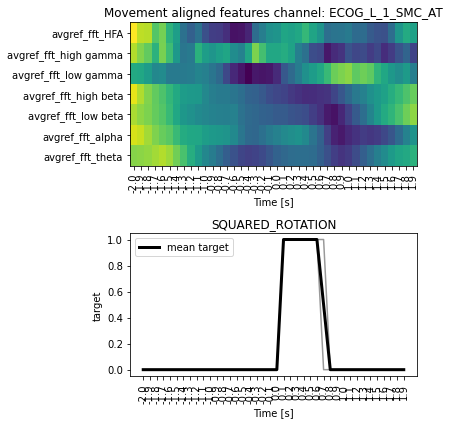

In [20]:
feature_reader.plot_target_averaged_channel(
    ch=ch_used,
    list_feature_keywords=[feature_used],
    epoch_len=4,   # Length of epoch in seconds
    threshold=0.5, # Threshold to be used for identifying events
)

## Grid Projection

When defining our settings, we set in the post-processing step:

```stream.settings['postprocessing']['project_cortex'] = True```
```stream.settings['postprocessing']['project_subcortex'] = True```

This means that we take all the computed features and check for every given grid point if there is any electrode channel in reach. If so, we interpolate for every grid point the channels within the range ```max_dist``` by their respective inverse distance. This gives us a projection matrix that we constantly apply, to go from the feature-channel matrix (n_features, n_channels) to the grid point matrix (n_features, n_gridpoints).


__QUESTION: HOW ARE THOSE GRID POINTS ESTABLISHED? WHY DO THEY EXIST? WHY DO WE APPLY THIS MATRIX? WHY IS THIS MATRIX NOT PRECOMPUTED? WHY IS THIS A POST PROCESSING STEP IF WE HAVE SAVED ```grid_cortex.tsv```? WHY IS THE GRID PROJECTION IN FeatureEstimationDemo.ipynb DONE before THE FEATURE ESTIMATION STEP (if project_cortex is a postprocessing step)? IS THERE A DIFFERENCE BETWEEN THAT GRID PROJECTION AND WHAT I WOULD GET AFTER THE POST-PROCESSING?__

FROM FeatureEstimationDemo:
"Next we will read the cortical grid, defined in ```pyneuromodulation/grid_cortex.tsv```, and calculate the projection matrix from individual channels to the grid. But first we read a standard MNI hull, defined in the plot folder:"

<font color='green'>The grid points are setup by Julian to cover a reasonable part of the cortex. They are used for across patient decoding. You will see that in the ECoG datasets the electrode locations are never the same. We interpolate to this grid s.t. they are common across patients. Check this paper that introduced the same concept: https://iopscience.iop.org/article/10.1088/1741-2552/abda0b (actually long after we had setup the idea for that...)

This is a post processing step since it is done after the features were computed. Also the feature normalization is therefore a "postprocessing" step.

The grid projection is done after the feature estimation, see nm_run_analysis.py line 157. The features were already computed and saved in the feature_dict.

And the matrix is in fact precomputed, check nm_projection.py line 71. It is then only applied for computational speed reasons.</font>

In [21]:
PATH_PLOT =os.path.join(os.pardir, 'py_neuromodulation','plots')
faces = io.loadmat(os.path.join(PATH_PLOT, 'faces.mat'))
vertices = io.loadmat(os.path.join(PATH_PLOT, 'Vertices.mat'))
grid = io.loadmat(os.path.join(PATH_PLOT, 'grid.mat'))['grid']
x_ecog = vertices['Vertices'][::1,0]
y_ecog = vertices['Vertices'][::1,1]
z_ecog = vertices['Vertices'][::1,2]

Since the grid is defined for the left hemisphere, we might switch the x coordinates for right electrodes. Then the ECoG channel coordinates and used grid points are visualized:

__THIS CELL BELOW DOESNT RUN. nm_BIDS doesnt exist anymore.__

<font color='green'>Feel free to delete :)</font>

cortex_grid = np.array(nm_BIDS.projection.grid_cortex.T)

if nm_BIDS.settings_wrapper.settings["sess_right"] is True:
    cortex_grid[0,:] = cortex_grid[0,:]*-1
    ecog_strip = np.array(nm_BIDS.settings_wrapper.settings["coord"]["cortex_right"]["positions"]).T
else:
    ecog_strip = np.array(nm_BIDS.settings_wrapper.settings["coord"]["cortex_left"]["positions"]).T


fig, axes = plt.subplots(1,1, facecolor=(1,1,1), \
                        figsize=(14,9))#, dpi=300)
axes.scatter(x_ecog, y_ecog, c="gray", s=0.001)
axes.axes.set_aspect('equal', anchor='C')

grid_color = nm_BIDS.projection.proj_matrix_cortex.sum(axis=1)
pos_ecog = axes.scatter(cortex_grid[0,:],
                        cortex_grid[1,:], c=grid_color,
                        s=30, alpha=0.8, cmap="viridis", label="cortical grid projection")

pos_elec = axes.scatter(ecog_strip[0,:],
                        ecog_strip[1,:], c=np.ones(ecog_strip.shape[1]),
                        s=50, alpha=0.8, cmap="gray", marker="x", label="ecog strip electrode contacts")
axes.legend(loc='best')
axes.axis('off')

__WOULD THIS COMMAND BELOW DO THE SAME THING?__

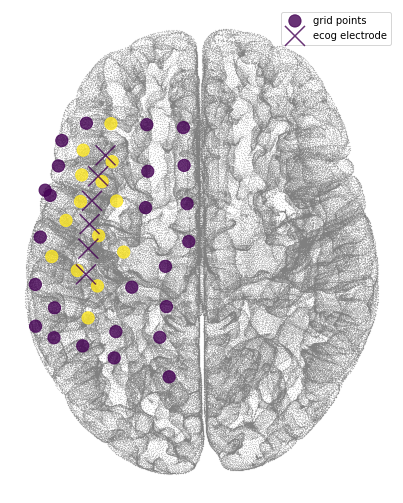

In [42]:
feature_reader.plot_cort_projection()

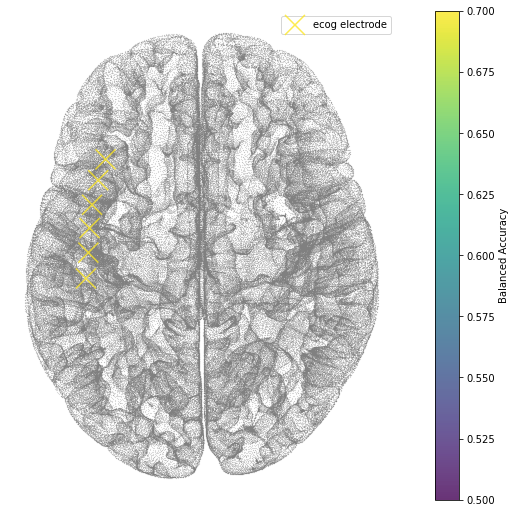

In [41]:
feature_reader.nmplotter.plot_cortex(ecog_strip=np.array(
    feature_reader.sidecar["coords"]["cortex_left"]["positions"],
))

In [ ]:
feature_reader.nmplotter.plot_cortex(np.array(
    feature_reader.sidecar["grid_cortex"],
     
))

In [18]:
# feature_reader.nmplotter.plot_cortex()

Function above could never work without passing any arguments because:

In [19]:
print(feature_reader.nmplotter.grid_cortex)
print(feature_reader.nmplotter.ecog_strip)

None
None


<font color='green'>Yes, I usually intended to call it from nm_analysis. Do you think refactoring makes sense to only call plotting functions from nm_plotter?
I also show now an example that calles the plotting function with the ecog_strip and grid_cortex only.</font>

 def plot_cortex(
        self,
        grid_cortex: Optional[np.ndarray] = None,
        grid_color: Optional[np.ndarray] = None,
        ecog_strip: Optional[np.ndarray] = None,
        strip_color: Optional[np.ndarray] = None,
        sess_right: Optional[bool] = None,
        save: bool = False,
        OUT_PATH: str = None,
        feature_file: str = None,
        feature_str_add: str = None,
        show_plot: bool = True,
        set_clim: bool = True,
        lower_clim: float = 0.5,
        upper_clim: float = 0.7,
    )

# Problem Alert:

The way it currently is, grid_cortex and the others are in practice not optional, because of feature_reader.nmplotter.grid_cortex = None.

I can do the plotting by:

Getting the grid cortex and grid subcortex from feature_reader.sidecar, but it seems like a bug that in nm_plots it reads from feature_reader.nmplotter and in there grid_cortex and ecog_strip are None.

For the grid_color I sum on axis = 1 because this is what is done in FeatureEstimationDemo.ipynb.

In [20]:
feature_reader.sidecar

{'original_fs': 1375.0,
 'sfreq': 1000,
 'sess_right': False,
 'coords': {'cortex_left': {'ch_names': ['ECOG_L_1_SMC_AT',
    'ECOG_L_2_SMC_AT',
    'ECOG_L_3_SMC_AT',
    'ECOG_L_4_SMC_AT',
    'ECOG_L_5_SMC_AT',
    'ECOG_L_6_SMC_AT'],
   'positions': [[-47.0, -26.0, 65.0],
    [-46.0, -15.5, 63.0],
    [-45.5, -5.5, 60.5],
    [-44.5, 4.0, 57.5],
    [-42.0, 14.0, 53.5],
    [-39.0, 22.5, 49.5]]},
  'cortex_right': {'ch_names': [], 'positions': []},
  'subcortex_left': {'ch_names': ['LFP_L_1_STN_BS',
    'LFP_L_234_STN_BS',
    'LFP_L_567_STN_BS'],
   'positions': [[-11.3, -15.9, -9.9],
    [-11.8, -15.0, -7.7],
    [-12.39, -14.29, -5.9]]},
  'subcortex_right': {'ch_names': ['LFP_R_234_STN_BS', 'LFP_R_567_STN_BS'],
   'positions': [[12.93, -13.41, -4.1], [13.4, -12.52, -2.2]]}},
 'grid_cortex': [[-13.1, -67.7, 69.1],
  [-35.5, -60.0, 66.0],
  [-48.3, -55.1, 58.2],
  [-60.0, -51.8, 48.0],
  [-16.9, -51.6, 78.0],
  [-34.8, -49.3, 71.7],
  [-67.5, -47.1, 31.0],
  [-46.1, -43.7, 61.1],

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


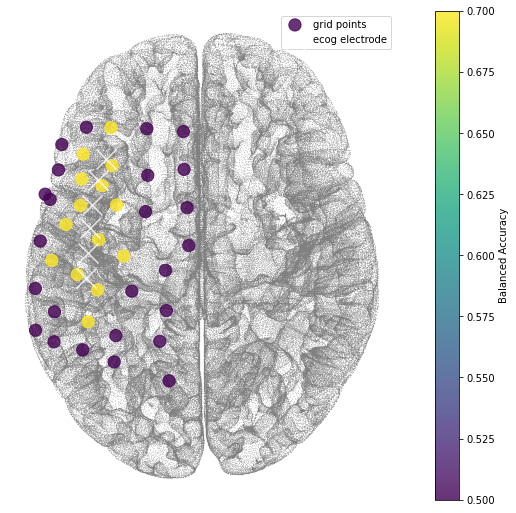

In [38]:
feature_reader.nmplotter.plot_cortex(grid_cortex=np.array(feature_reader.sidecar['grid_cortex']), ecog_strip=np.array(feature_reader.sidecar['coords']['cortex_left']['positions']), grid_color= np.array(feature_reader.sidecar['proj_matrix_cortex']).sum(axis=1), strip_color= np.ones(np.array(feature_reader.sidecar['coords']['cortex_left']['positions']).shape[1]))

# From FeatureEstimationDemo.ipynb :
#grid_color = nm_BIDS.projection.proj_matrix_cortex.sum(axis=1)

Still need legend!! How to do it?

#### <font color='green'>Good Point! it can be added with plt.legend() in the nm_plots.plot_cortex() function
I did that now</font>

## Sharpwave Features

__Sharpwave features need to wait until the problem in nm_sharpwaves.py is fixed!!!__

## Decoding With a Different Machine Learning Model

If the user wants to use their preferred model, they only need to import it and pass it to the nm_decode.Decoder(model=preferred_model).

Same thing if the user wants to use a different cross-validation method,nm_decode.Decoder(cv_method=preferred_method).

no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movements in label
no movemen

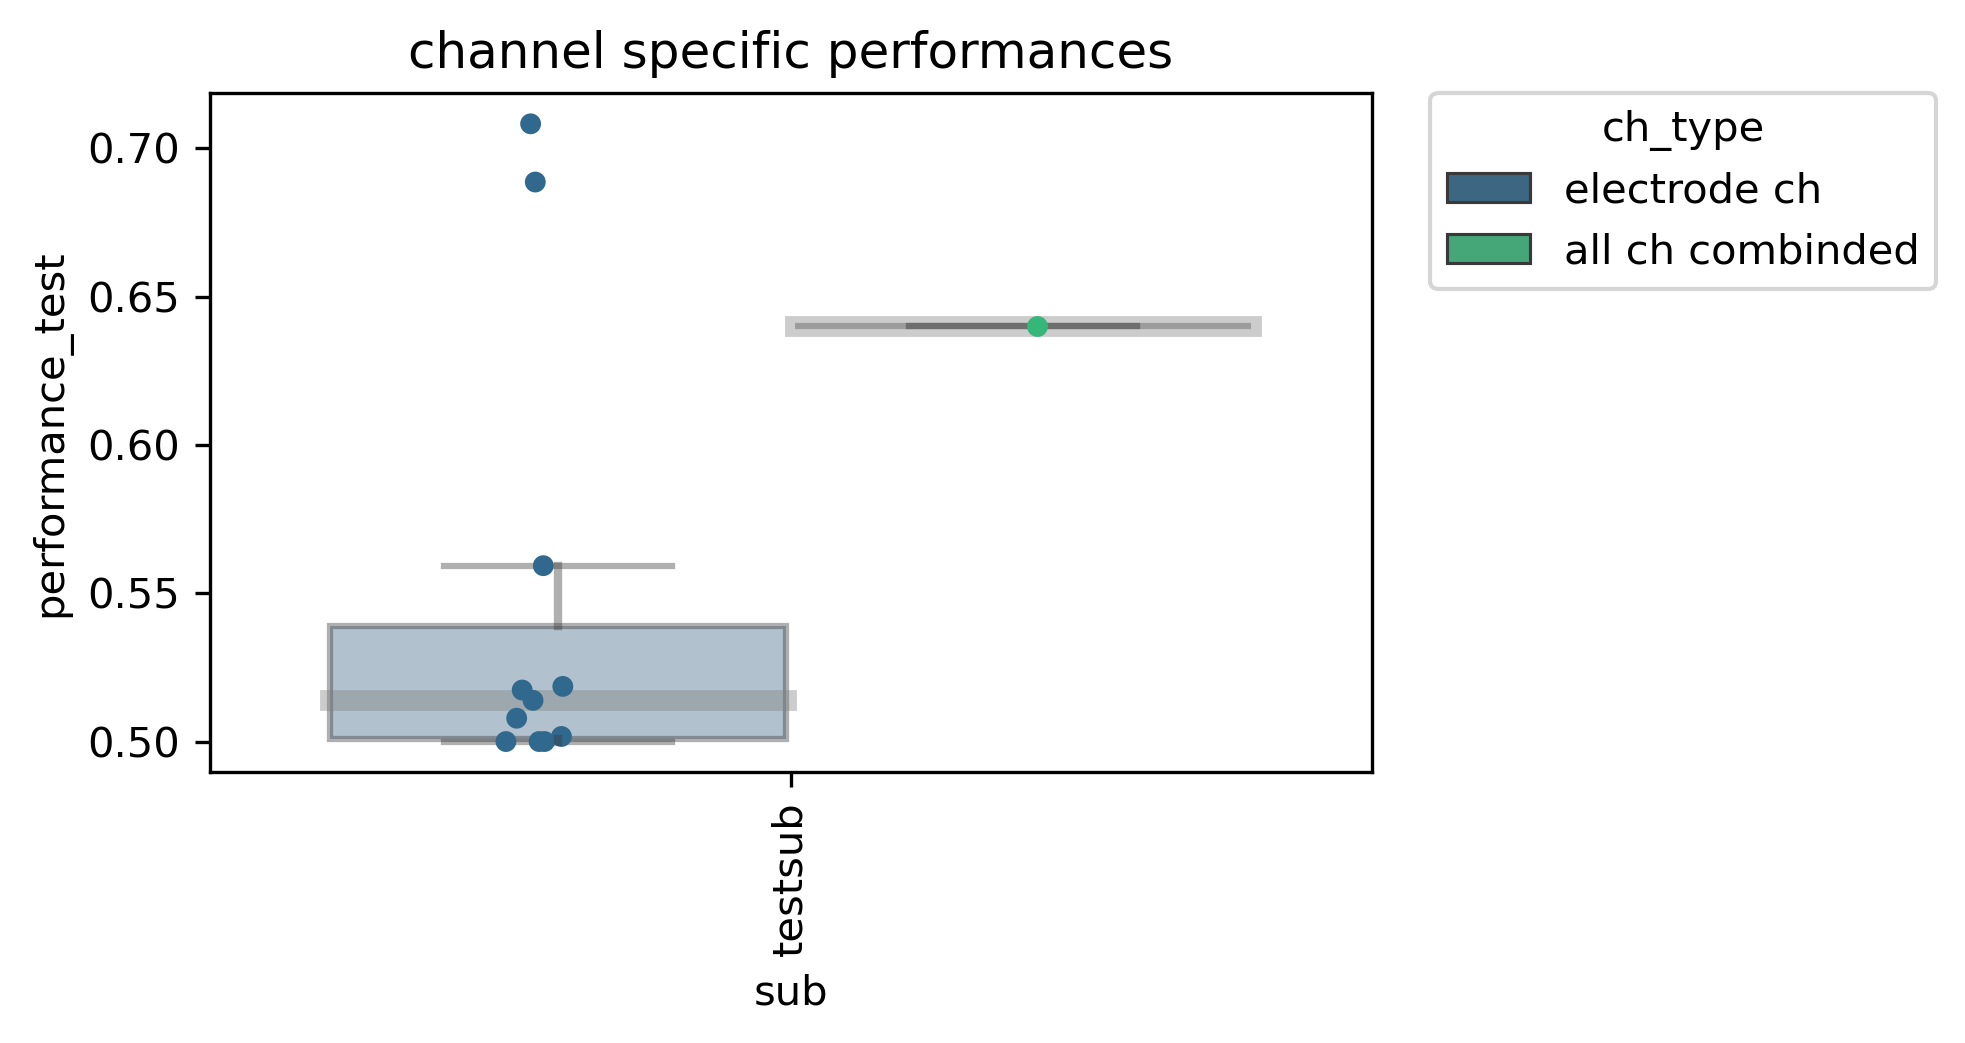

In [36]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(penalty="l2", max_iter=5)
# loss = 'log_loss' because it gives a logistic regression, a probabilistic classifier.

feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.balanced_accuracy_score,
    cv_method=model_selection.RepeatedKFold(n_splits=3, n_repeats=2),
    get_movement_detection_rate=True,
    min_consequent_count=2,
    TRAIN_VAL_SPLIT=False,
    RUN_BAY_OPT=False,
    bay_opt_param_space=None,
    use_nested_cv=True,
    sfreq=feature_reader.settings["sampling_rate_features_hz"],
)

performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

df_per = feature_reader.get_dataframe_performances(performances)

nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)